In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

In [ ]:
df = pd.read_csv("dutch_graph_t_0.csv", skip_blank_lines=True, header=0)
df.drop(df.columns[0], axis=1, inplace=True)

In [ ]:
G = nx.from_pandas_edgelist(df, 'successor', 'predecessor', create_using=nx.DiGraph)

In [ ]:
# in case of error see: https://stackoverflow.com/questions/15661384/python-does-not-see-pygraphviz
# run !sudo apt-get install graphviz libgraphviz-dev pkg-config
# !pip install pygraphviz
pos=graphviz_layout(G,prog='dot')

In [ ]:
list(nx.selfloop_edges(G))

[(1, 1)]

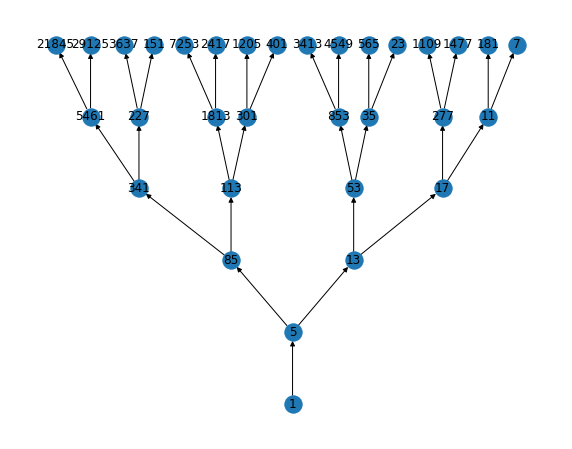

In [ ]:
plt.figure(figsize=(10, 8))
plt.gca().invert_yaxis()
nx.draw(G, with_labels=True, arrows=True, pos=pos)